In [1]:
import os
import random
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.layers import Input, Dense, Flatten
import keras.utils as image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Print TensorFlow version
print("TensorFlow Version:", tf.__version__)

# Check if GPU device is available
print("Is GPU available:", tf.test.is_gpu_available())

# List of available GPUs
print("List of GPUs:", tf.config.experimental.list_physical_devices('GPU'))

# Additional GPU information
if tf.config.experimental.list_physical_devices('GPU'):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        print("Name:", gpu.name, " Type:", gpu.device_type)

TensorFlow Version: 2.10.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True
List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Name: /physical_device:GPU:0  Type: GPU


In [3]:
root = 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\accordion', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\anchor', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\ant', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\barrel', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\bass', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\beaver', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\binocular', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\bonsai', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\brain', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\brontosaurus', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\buddha', 'C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\\butterfly', 'C:/Users/USER/Downloads/calte

In [4]:
def get_image(path):
    img = image.load_img(path, target_size=(180, 180))  # Changed the target size to 224x224
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [6]:
random.shuffle(data)

In [7]:
# create training / validation / test split (70%, 15%, 15%)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [8]:
# Separate data for labels.
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[82, 60, 63, 10, 17, 82, 41, 91, 15, 55, 96, 96, 90, 81, 1, 71, 70, 27, 26, 84, 66, 79, 25, 27, 30, 62, 8, 61, 2, 14, 77, 16, 85, 9, 53, 27, 53, 83, 59, 10, 36, 82, 17, 92, 35, 65, 21, 54, 7, 83, 10, 57, 41, 90, 75, 7, 19, 3, 34, 88, 82, 59, 29, 3, 41, 42, 30, 1, 7, 34, 79, 11, 10, 56, 42, 75, 50, 87, 76, 84, 17, 40, 52, 22, 61, 72, 62, 90, 20, 77, 67, 49, 27, 2, 70, 96, 9, 17, 65, 18, 33, 34, 63, 22, 89, 7, 80, 87, 54, 42, 51, 22, 76, 5, 94, 49, 11, 24, 64, 48, 80, 36, 96, 17, 16, 40, 88, 44, 51, 11, 69, 18, 88, 53, 10, 29, 45, 59, 82, 57, 5, 24, 90, 8, 58, 44, 3, 35, 21, 47, 38, 8, 52, 23, 36, 69, 28, 33, 7, 87, 28, 37, 91, 31, 90, 11, 35, 32, 45, 18, 13, 21, 94, 18, 53, 90, 36, 55, 82, 90, 87, 39, 85, 46, 77, 96, 52, 6, 7, 53, 6, 14, 50, 80, 6, 73, 18, 11, 18, 10, 80, 89, 52, 6, 89, 27, 16, 85, 28, 11, 93, 41, 46, 70, 64, 21, 80, 52, 24, 71, 32, 0, 40, 44, 43, 26, 48, 14, 46, 11, 31, 7, 14, 59, 14, 83, 8, 22, 37, 54, 94, 59, 72, 42, 36, 34, 57, 90, 49, 93, 7, 40, 7, 90, 46, 29, 5, 7

In [9]:
# Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.
# normalize data
x_train = x_train.astype('float32') / 127.5 - 1.
x_val = x_val.astype('float32') / 127.5 - 1.
x_test = x_test.astype('float32') / 127.5 -1.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 180, 180, 3)
training labels shape:  (4346, 97)


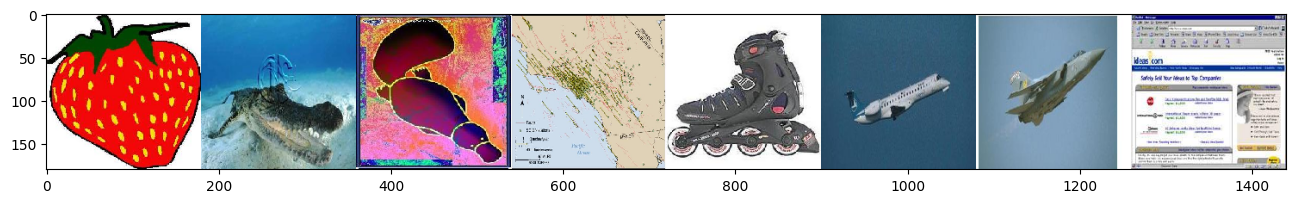

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(180, 180)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (180, 180, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 87, 87, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                   

In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=8,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
544/544 [==============================] - 8s 9ms/step - loss: 4.4718 - accuracy: 0.0492 - val_loss: 4.2890 - val_accuracy: 0.0870
Epoch 2/10
544/544 [==============================] - 5s 9ms/step - loss: 4.0133 - accuracy: 0.1376 - val_loss: 3.7003 - val_accuracy: 0.2180
Epoch 3/10
544/544 [==============================] - 5s 8ms/step - loss: 3.3871 - accuracy: 0.2395 - val_loss: 3.0817 - val_accuracy: 0.3029
Epoch 4/10
544/544 [==============================] - 5s 8ms/step - loss: 2.9120 - accuracy: 0.3249 - val_loss: 2.7331 - val_accuracy: 0.3888
Epoch 5/10
544/544 [==============================] - 5s 9ms/step - loss: 2.4943 - accuracy: 0.3992 - val_loss: 2.6608 - val_accuracy: 0.4211
Epoch 6/10
544/544 [==============================] - 5s 8ms/step - loss: 2.1983 - accuracy: 0.4678 - val_loss: 2.4934 - val_accuracy: 0.4586
Epoch 7/10
544/544 [==============================] - 5s 8ms/step - loss: 1.8668 - accuracy: 0.5278 - val_loss: 2.4146 - val_accuracy: 0.4683
Epoch 

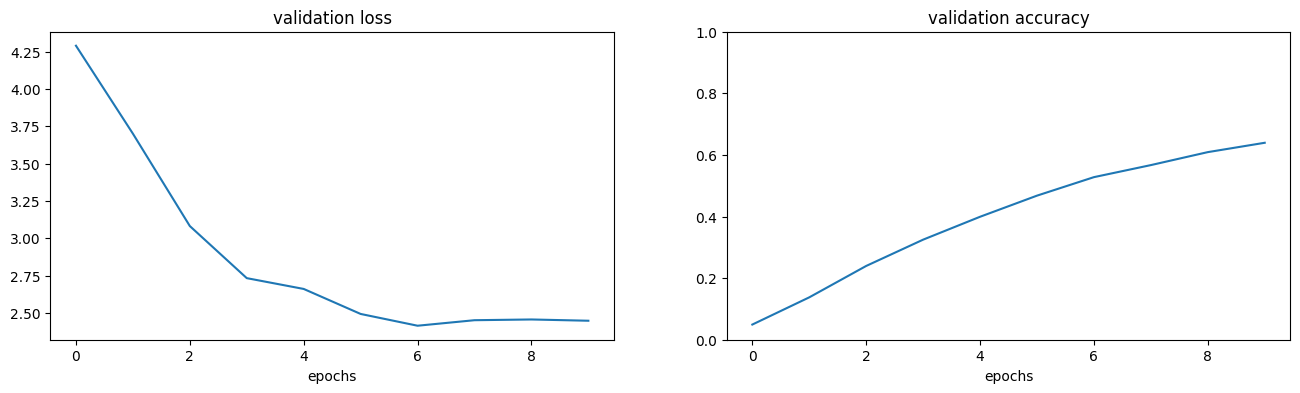

In [14]:
# Learning rate
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [15]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.454021692276001
Test accuracy: 0.45064377784729004


In [16]:
# Importing weights ans biases from a previous trained network
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
#This can be done in the following way, by using the keras Model class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called new_classification_layer
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np  # Assuming NumPy is not already imported

# Assume model_new is your pre-loaded model
# model_new = ...

# Create a new input layer with shape (128, 128, 3)
new_input_layer = Input(shape=(180, 180, 3))

# Stack convolutional and pooling layers from the original model onto the new input layer
new_output = new_input_layer
for layer in model_new.layers[1:]:
    if 'fc' in layer.name:  # Stop before fully connected layers
        break
    new_output = layer(new_output)

# Create a model to get the shape of the output feature map
intermediate_model = Model(inputs=new_input_layer, outputs=new_output)
shape_after_conv = intermediate_model.predict(np.zeros((1, 180, 180, 3))).shape

# Flatten the output feature map and add reduced fully connected layers
new_output = Flatten()(new_output)
new_output = Dense(4096, activation='relu', name='new_fc1')(new_output)  # Reduced from 4096 to 1024
new_output = Dense(4096, activation='relu', name='new_fc2')(new_output)  # Reduced from 4096 to 1024
new_output = Dense(num_classes, activation='softmax', name='new_predictions')(new_output)  # Keep this the same

# Create the new model
new_model = Model(inputs=new_input_layer, outputs=new_output)

# Make all layers untrainable by freezing weights (except for last layer)
for layer in new_model.layers[:-1]:
    layer.trainable = False

# Ensure the last layer is trainable/not frozen
new_model.layers[-1].trainable = True

# Compile the new model
new_model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

# Display the model's architecture
new_model.summary()

1/1 [==============================] - 1s 728ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       multiple                  1792      
                                                                 
 block1_conv2 (Conv2D)       multiple                  36928     
                                                                 
 block1_pool (MaxPooling2D)  multiple                  0         
                                                                 
 block2_conv1 (Conv2D)       multiple                  73856     
                                                                 
 block2_conv2 (Conv2D)       multiple                  147584    
                                                                 
 block

In [19]:
# # make all layers untrainable by freezing weights (except for last layer)
# for l, layer in enumerate(model_new.layers[:-1]):
#     layer.trainable = False

# # ensure the last layer is trainable/not frozen
# for l, layer in enumerate(model_new.layers[-1:]):
#     layer.trainable = True

# model_new.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model_new.summary()

In [66]:
history2 = new_model.fit(x_train, y_train, 
                         batch_size=6, 
                         epochs=10, 
                         validation_data=(x_val, y_val))


Epoch 1/10
725/725 [==============================] - 15s 20ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.7166 - val_accuracy: 0.8571
Epoch 2/10
725/725 [==============================] - 14s 20ms/step - loss: 4.0782e-05 - accuracy: 1.0000 - val_loss: 0.6844 - val_accuracy: 0.8571
Epoch 3/10
725/725 [==============================] - 15s 20ms/step - loss: 2.3184e-05 - accuracy: 1.0000 - val_loss: 0.6649 - val_accuracy: 0.8614
Epoch 4/10
725/725 [==============================] - 15s 21ms/step - loss: 1.8471e-05 - accuracy: 1.0000 - val_loss: 0.6480 - val_accuracy: 0.8614
Epoch 5/10
725/725 [==============================] - 15s 21ms/step - loss: 1.5107e-05 - accuracy: 1.0000 - val_loss: 0.6335 - val_accuracy: 0.8647
Epoch 6/10
725/725 [==============================] - 15s 21ms/step - loss: 1.2673e-05 - accuracy: 1.0000 - val_loss: 0.6191 - val_accuracy: 0.8679
Epoch 7/10
725/725 [==============================] - 15s 21ms/step - loss: 1.0820e-05 - accuracy: 1.0000 - val_loss

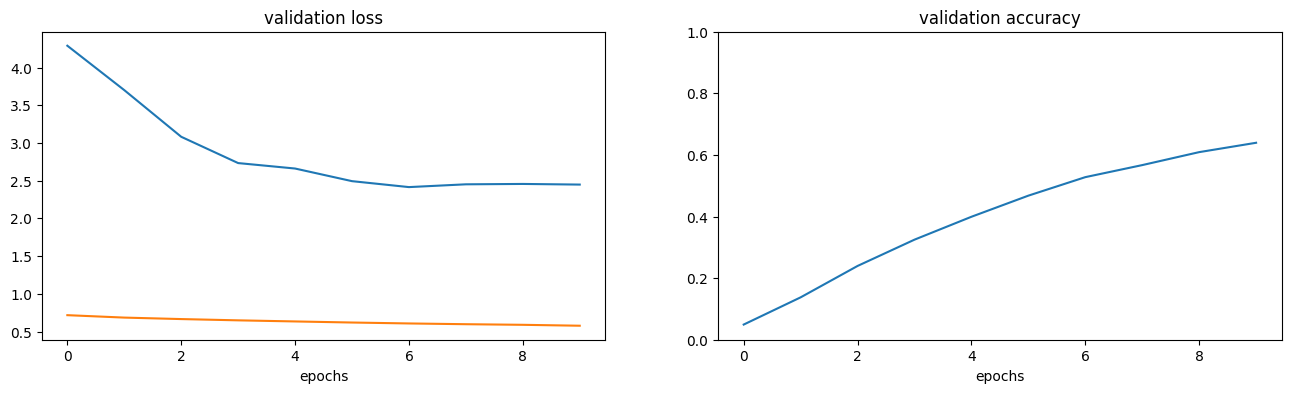

In [67]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.plot(history2.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [68]:
loss, accuracy = new_model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.47976183891296387
Test accuracy: 0.8851931095123291


In [78]:

# Assuming model_new is the model you've trained or modified
# model_new = ...

# Get the image and preprocess it
img, x = get_image("C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories/dollar_bill/image_0012.jpg")

# Make predictions
probabilities = new_model.predict(x)

# Find the index of the class with maximum probability
predicted_class_index = np.argmax(probabilities[0])

# Assuming categories is your list of category names
# categories = ['Category_0', 'Category_1', 'Category_2', ..., 'Category_n']

# Get the name of the class
predicted_class_name = categories[predicted_class_index]

# Assuming accuracy is the variable you want to display
# accuracy = ...

# Output the most likely class and its accuracy
print(f"The most likely class is: {predicted_class_name} with accuracy {accuracy}")


1/1 [==============================] - 0s 25ms/step
The most likely class is: C:/Users/USER/Downloads/caltech-101/caltech-101/101_ObjectCategories\dollar_bill with accuracy 0.8851931095123291
